## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

NameError: name 'np' is not defined


dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
import statistics
statistics.variance(np.nan_to_num(dat['pupilCOM'][:,0]))

119.95257207571328

In [ ]:
statistics.variance(np.nan_to_num(dat['pupilCOM'][:,1]))

16.663050573061398

In [ ]:
dat['sresp']

In [ ]:
len(np.where(np.isnan(dat['pupilCOM'])))

2

In [ ]:
test = np.where(np.isnan(dat['pupilCOM'][:,1]))
len(test[0])

17

(array([  3.,   2.,   1.,   6.,   7.,   9.,   9.,  18.,  29.,  27.,  45.,
         46.,  60.,  50.,  58.,  80.,  86.,  97., 114., 136., 158., 153.,
        161., 220., 271., 274., 311., 312., 315., 348., 458., 543., 570.,
        444., 268., 202., 226., 177., 165., 152., 122.,  88.,  66.,  52.,
         37.,  15.,   4.,   3.,   1.,   2.]),
 array([ 44.94922882,  46.29737618,  47.64552354,  48.9936709 ,
         50.34181826,  51.68996562,  53.03811298,  54.38626035,
         55.73440771,  57.08255507,  58.43070243,  59.77884979,
         61.12699715,  62.47514451,  63.82329187,  65.17143923,
         66.51958659,  67.86773395,  69.21588131,  70.56402867,
         71.91217603,  73.26032339,  74.60847075,  75.95661811,
         77.30476547,  78.65291283,  80.00106019,  81.34920755,
         82.69735491,  84.04550227,  85.39364963,  86.74179699,
         88.08994435,  89.43809171,  90.78623907,  92.13438643,
         93.4825338 ,  94.83068116,  96.17882852,  97.52697588,
         98.875123

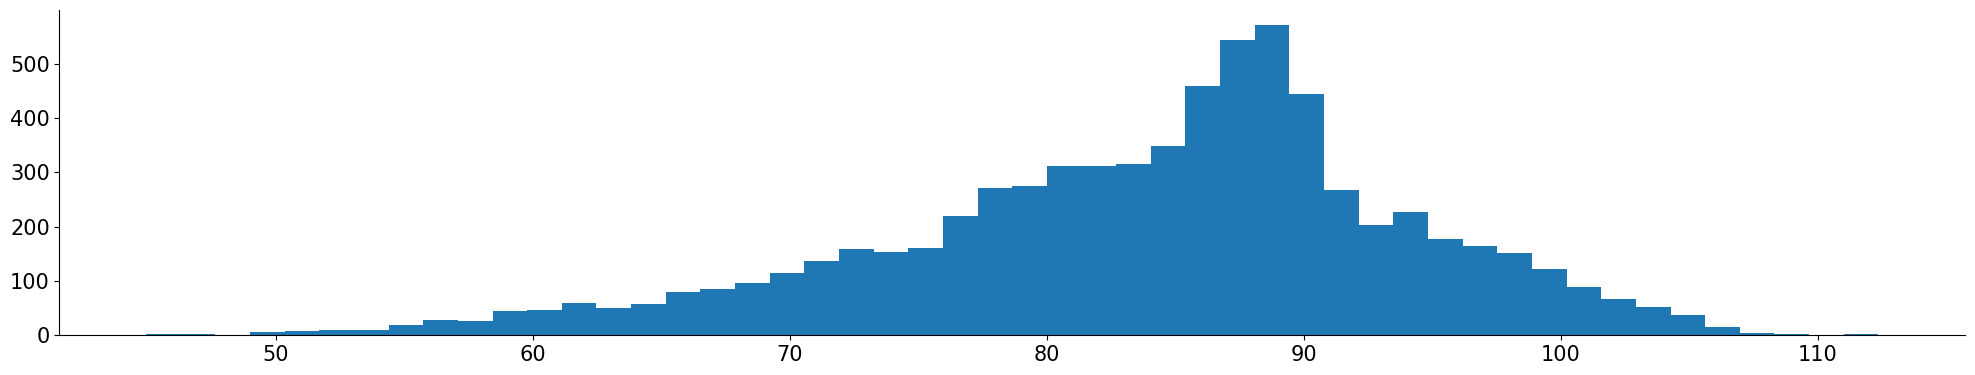

In [ ]:
plt.hist(dat['pupilCOM'][:,0], bins=50)

(array([1.700e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        7.400e+01, 2.229e+03, 4.465e+03, 2.320e+02]),
 array([ 0.        ,  6.39338619, 12.78677237, 19.18015856, 25.57354475,
        31.96693093, 38.36031712, 44.75370331, 51.14708949, 57.54047568,
        63.93386187]),
 <BarContainer object of 10 artists>)

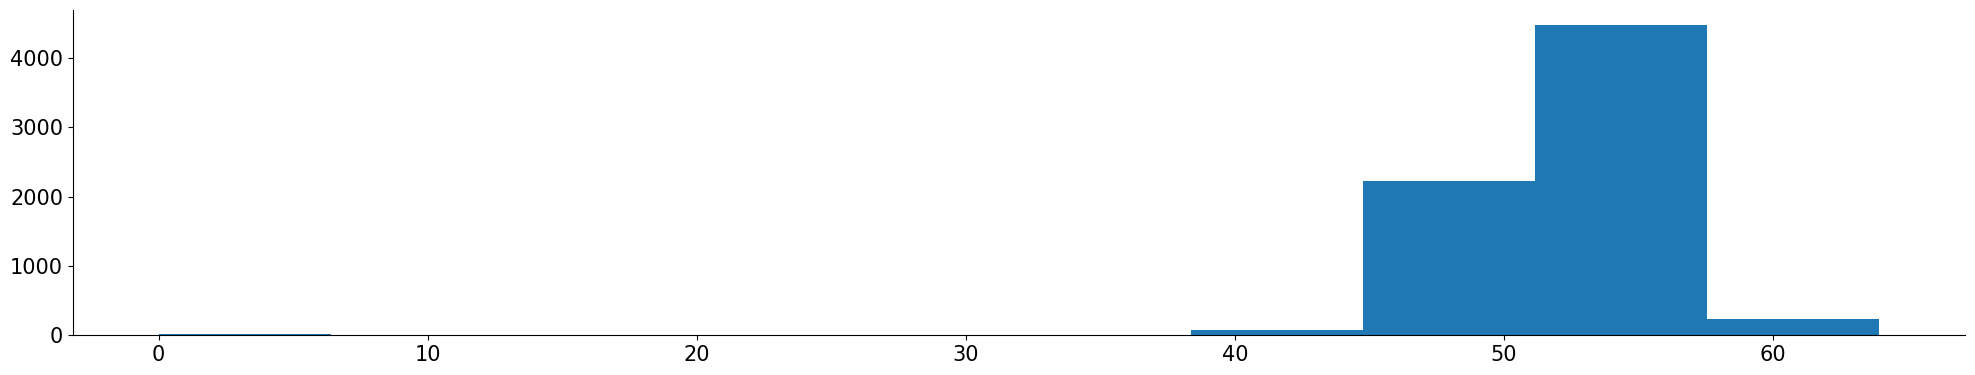

In [ ]:
plt.hist(np.nan_to_num(dat['pupilCOM'][:,1]))

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stringer_full.csv')

In [ ]:
rel_change = results[results['Eye_Mov']=='RelativeChange']

In [ ]:
rel_change = rel_change[rel_change['TimeSplit']>4]
rel_change.shape

(135, 10)

In [ ]:
means = rel_change.groupby(['TimeBin', 'Depth']).mean()
means

<ipython-input-29-26d1f281518b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = rel_change.groupby(['TimeBin', 'Depth']).mean()


Unnamed: 0  TimeSplit       MAE       MSE   MedianE        R2  \
TimeBin Depth                                                                  
-1      1           817.0        7.0  1.602169  8.530449  0.895294  0.046808   
        2           847.0        7.0  1.608958  8.579281  0.905643  0.044232   
        3           877.0        7.0  1.609008  8.471421  0.929203  0.055283   
        4           907.0        7.0  1.625804  8.290782  0.961497  0.066255   
        5           937.0        7.0  1.591403  8.094861  0.934073  0.076296   
        6           967.0        7.0  1.624672  8.258922  0.969509  0.069563   
        7           997.0        7.0  1.596375  8.135981  0.937370  0.083587   
        8          1027.0        7.0  1.625926  8.355721  0.972042  0.059102   
        9          1057.0        7.0  1.623227  8.565585  0.926835  0.044217   
 0      1           827.0        7.0  1.445154  5.490194  0.985893  0.259284   
        2           857.0        7.0  1.413296  5.281164  0.968732  0.270335   
        3           887.0        7.0  1.467591  5.692034  1.005106  0.243892   
        4           917.0        7.0  1.420867  5.203332  0.988455  0.281264   
        5           947.0        7.0  1.437334  5.305069  1.005217  0.270414   
        6           977.0        7.0  1.466941  5.513816  1.020389  0.254835   
        7          1007.0        7.0  1.492067  5.664905  1.049651  0.245524   
        8          1037.0        7.0  1.545331  6.429322  1.079945  0.197286   
        9          1067.0        7.0  1.615952  7.558582  1.040478  0.123114   
 1      1           837.0        7.0  1.570099  7.656348  0.954626  0.107946   
        2           867.0        7.0  1.548010  7.549595  0.918146  0.124367   
        3           897.0        7.0  1.557433  7.583024  0.938299  0.120071   
        4           927.0        7.0  1.536156  7.301365  0.956899  0.141211   
        5           957.0        7.0  1.536746  7.262068  0.930585  0.138153   
        6           987.0        7.0  1.566016  7.452124  0.982652  0.129861   
        7          1017.0        7.0  1.556925  7.258382  0.982677  0.135094   
        8          1047.0        7.0  1.595892  7.483192  1.033312  0.116896   
        9          1077.0        7.0  1.584291  7.716535  0.990909  0.099083   

                Exp_Var  
TimeBin Depth            
-1      1      0.048427  
        2      0.045824  
        3      0.058657  
        4      0.069580  
        5      0.077859  
        6      0.074037  
        7      0.085019  
        8      0.062546  
        9      0.045822  
 0      1      0.260697  
        2      0.273635  
        3      0.244913  
        4      0.283781  
        5      0.272842  
        6      0.258014  
        7      0.249231  
        8      0.205218  
        9      0.125787  
 1      1      0.110506  
        2      0.126273  
        3      0.121557  
        4      0.142386  
        5      0.139442  
        6      0.131110  
        7      0.136171  
        8      0.118579  
        9      0.100265

In [ ]:
means.loc[-1]['MSE']

Depth
1    8.530449
2    8.579281
3    8.471421
4    8.290782
5    8.094861
6    8.258922
7    8.135981
8    8.355721
9    8.565585
Name: MSE, dtype: float64

In [ ]:
diffs = np.zeros((9,3))
for depth in range(1,10):
  diffs[depth-1] = np.array([np.abs(means.loc[-1]['MSE'][depth]-means.loc[0]['MSE'][depth]), np.abs(means.loc[-1]['MSE'][depth]-means.loc[1]['MSE'][depth]), np.abs(means.loc[0]['MSE'][depth]-means.loc[1]['MSE'][depth])])

diffs

array([[3.04025539, 0.87410142, 2.16615398],
       [3.29811749, 1.02968625, 2.26843124],
       [2.77938756, 0.8883973 , 1.89099026],
       [3.08745004, 0.98941697, 2.09803307],
       [2.7897918 , 0.83279291, 1.95699889],
       [2.74510636, 0.80679772, 1.93830865],
       [2.47107686, 0.87759967, 1.59347719],
       [1.92639858, 0.87252871, 1.05386986],
       [1.00700337, 0.84905006, 0.15795332]])

In [ ]:
diffdiffs = np.diff(diffs,axis=0)
testcase = np.sum(np.square(diffdiffs))

In [ ]:
testcase

3.252078624884475

In [ ]:
diffs = np.zeros((9,3))
for depth in range(1,10):
  diffs[depth-1] = np.array([np.abs(means.loc[-1]['R2'][depth]-means.loc[0]['R2'][depth]), np.abs(means.loc[-1]['R2'][depth]-means.loc[1]['R2'][depth]), np.abs(means.loc[0]['R2'][depth]-means.loc[1]['R2'][depth])])

diffs

array([[0.21247654, 0.06113868, 0.15133786],
       [0.22610342, 0.08013537, 0.14596806],
       [0.18860934, 0.06478838, 0.12382096],
       [0.21500923, 0.07495618, 0.14005306],
       [0.19411757, 0.06185641, 0.13226116],
       [0.18527182, 0.06029795, 0.12497387],
       [0.16193698, 0.05150686, 0.11043013],
       [0.13818406, 0.05779449, 0.08038957],
       [0.07889731, 0.05486612, 0.02403119]])

In [ ]:
diffdiffs = np.diff(diffs,axis=0)
testcase = np.sum(np.square(diffdiffs))
np.where(permutations<=testcase)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),)

In [ ]:
permutations = []
depths = list(set(rel_change['Depth'].values))
for i in range(1000):
  np.random.shuffle(depths)
  depth = depths[0]
  diffs = np.array([[np.abs(means.loc[-1]['R2'][depth]-means.loc[0]['R2'][depth]), np.abs(means.loc[-1]['R2'][depth]-means.loc[1]['R2'][depth]), np.abs(means.loc[0]['R2'][depth]-means.loc[1]['R2'][depth])]])
  for depth in depths[1:]:
    diffs = np.concatenate((diffs, np.array([[np.abs(means.loc[-1]['R2'][depth]-means.loc[0]['R2'][depth]), np.abs(means.loc[-1]['R2'][depth]-means.loc[1]['R2'][depth]), np.abs(means.loc[0]['R2'][depth]-means.loc[1]['R2'][depth])]])),axis=0)
  diffdiff = np.diff(diffs,axis=0)
  permutations.append(np.sum(np.square(diffdiff)))


In [ ]:
np.min(permutations)

0.015323554733372718

In [ ]:
permutations = []
depths = list(set(rel_change['Depth'].values))
for i in range(1000):
  np.random.shuffle(depths)
  depth = depths[0]
  diffs = np.array([[np.abs(means.loc[-1]['MSE'][depth]-means.loc[0]['MSE'][depth]), np.abs(means.loc[-1]['MSE'][depth]-means.loc[1]['MSE'][depth]), np.abs(means.loc[0]['MSE'][depth]-means.loc[1]['MSE'][depth])]])
  for depth in depths[1:]:
    diffs = np.concatenate((diffs, np.array([[np.abs(means.loc[-1]['MSE'][depth]-means.loc[0]['MSE'][depth]), np.abs(means.loc[-1]['MSE'][depth]-means.loc[1]['MSE'][depth]), np.abs(means.loc[0]['MSE'][depth]-means.loc[1]['MSE'][depth])]])),axis=0)
  diffdiff = np.diff(diffs,axis=0)
  permutations.append(np.sum(np.square(diffdiff)))



In [ ]:
testcase = np.sum(np.square(diffdiffs))
np.where(permutations<=testcase)

(array([ 49, 426]),)

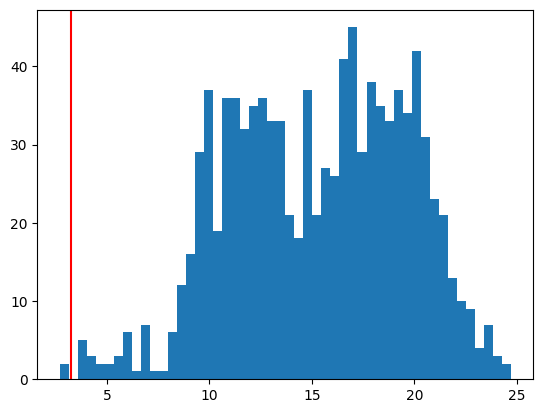

In [ ]:
plt.hist(permutations,bins=50)
plt.axvline(x=testcase, c='red')

In [ ]:
depth = depths[0]
diffs = np.array([[np.abs(means.loc[-1]['MSE'][depth]-means.loc[0]['MSE'][depth]), np.abs(means.loc[-1]['MSE'][depth]-means.loc[1]['MSE'][depth]), np.abs(means.loc[0]['MSE'][depth]-means.loc[1]['MSE'][depth])]])
for depth in depths[1:]:
  diffs = np.concatenate((diffs, np.array([[np.abs(means.loc[-1]['MSE'][depth]-means.loc[0]['MSE'][depth]), np.abs(means.loc[-1]['MSE'][depth]-means.loc[1]['MSE'][depth]), np.abs(means.loc[0]['MSE'][depth]-means.loc[1]['MSE'][depth])]])),axis=0)
diffs.shape

(9, 3)

In [ ]:
distance = results[results['Eye_Mov']=='Magnitude']
position = results[results['Eye_Mov']=='AbsolutePosition']
direction = results[results['Eye_Mov']=='Direction']
rel_change = results[results['Eye_Mov']=='RelativeChange']

In [ ]:
neg = results[results['TimeBin']==-1]
pos = results[results['TimeBin']==1]

360

In [ ]:
test = stats.kruskal(neg['Exp_Var'].values, pos['Exp_Var'].values)
print(test)

KruskalResult(statistic=28.339115554528234, pvalue=1.0181767742004008e-07)


In [ ]:
ttest = stats.ttest_ind(neg['Exp_Var'].values, pos['Exp_Var'].values)
print(ttest)

TtestResult(statistic=-5.114763077478343, pvalue=4.0347423155820297e-07, df=718.0)


In [ ]:
print(neg['Exp_Var'].var(), pos['Exp_Var'].var())

0.017033118990890182 0.019412616107629222


In [ ]:
results

,Unnamed: 0,Eye_Mov,TimeBin,Depth,TimeSplit,MAE,MSE,MedianE,R2,Exp_Var
0,0,Direction,-1,1,0,0.573738,0.497436,0.511213,-0.057284,-0.052939
1,1,Direction,-1,1,1,0.582492,0.507380,0.524879,-0.051383,-0.044286
2,2,Direction,-1,1,2,0.582414,0.456830,0.572103,0.036894,0.037347
3,3,Direction,-1,1,3,0.633005,0.526014,0.650327,-0.061395,-0.038374
4,4,Direction,-1,1,4,0.597922,0.480586,0.589877,-0.042056,-0.026530
...,...,...,...,...,...,...,...,...,...,...
1075,1075,RelativeChange,1,9,5,1.741699,9.133362,1.023245,0.074722,0.079118
1076,1076,RelativeChange,1,9,6,1.644613,8.338161,1.045317,0.107546,0.107643
1077,1077,RelativeChange,1,9,7,1.477026,6.989153,0.995902,0.110788,0.111169
1078,1078,RelativeChange,1,9,8,1.549900,7.246371,0.986718,0.087084,0.087913


In [ ]:
cleaned_results = results[results['TimeSplit']>=5]
len(cleaned_results)

540

In [ ]:
results.groupby('TimeSplit').mean().sort_values('Exp_Var', ascending=False)

<ipython-input-24-f599acbc9832>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results.groupby('TimeSplit').mean().sort_values('Exp_Var', ascending=False)


,Unnamed: 0,TimeBin,Depth,MAE,MSE,MedianE,R2,Exp_Var
TimeSplit,,,,,,,,
9,544.0,0.0,5.0,1.860765,8.876054,1.452372,0.142045,0.225309
7,542.0,0.0,5.0,2.031728,12.039496,1.626043,0.116584,0.216823
8,543.0,0.0,5.0,1.850610,8.739929,1.458155,0.080877,0.215863
6,541.0,0.0,5.0,1.990548,15.164583,1.465953,0.198945,0.213666
5,540.0,0.0,5.0,2.013936,11.176449,1.524320,0.187733,0.210960
1,536.0,0.0,5.0,2.493834,20.586556,1.895573,0.113147,0.160293
4,539.0,0.0,5.0,1.816980,16.014408,1.313267,0.135257,0.151496
0,535.0,0.0,5.0,2.558323,21.243700,1.901244,0.096819,0.128234
2,537.0,0.0,5.0,2.416697,22.198732,2.008515,-0.008220,0.078274


In [ ]:
results.groupby('TimeBin').mean()

<ipython-input-17-e15535cf1be2>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results.groupby('TimeBin').mean()


,Unnamed: 0,Depth,TimeSplit,MAE,MSE,MedianE,R2,Exp_Var
TimeBin,,,,,,,,
-1,529.5,5.0,4.5,2.211988,17.093746,1.701328,0.015040,0.086895
0,539.5,5.0,4.5,1.970832,12.950858,1.544978,0.166614,0.230477
1,549.5,5.0,4.5,2.112523,14.768225,1.644282,0.074202,0.138358


In [ ]:
cleaned_results.groupby('TimeBin').mean()

<ipython-input-26-43237e7e1660>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cleaned_results.groupby('TimeBin').mean()


,Unnamed: 0,Depth,TimeSplit,MAE,MSE,MedianE,R2,Exp_Var
TimeBin,,,,,,,,
-1,532.0,5.0,7.0,2.068749,13.071988,1.576017,0.069380,0.146556
0,542.0,5.0,7.0,1.819604,9.435696,1.423266,0.232021,0.301368
1,552.0,5.0,7.0,1.960200,11.090223,1.516823,0.134309,0.201648


In [ ]:
neutral = cleaned_results[cleaned_results['TimeBin']==0]
neutral.groupby('Eye_Mov').mean().sort_values('R2', ascending=False)

,Unnamed: 0,TimeBin,Depth,TimeSplit,MAE,MSE,MedianE,R2,Exp_Var
Eye_Mov,,,,,,,,,
Magnitude,407.0,0.0,5.0,7.0,1.724357,6.434956,1.190651,0.459153,0.463330
RelativeChange,947.0,0.0,5.0,7.0,1.478282,5.793157,1.015985,0.238439,0.241569
Direction,137.0,0.0,5.0,7.0,0.511896,0.385251,0.459958,0.150619,0.158976
AbsolutePosition,677.0,0.0,5.0,7.0,3.563881,25.129419,3.026470,0.079872,0.341598


In [ ]:
pos = cleaned_results[cleaned_results['TimeBin']==1]
pos.groupby('Eye_Mov').mean().sort_values('R2', ascending=False)

,Unnamed: 0,TimeBin,Depth,TimeSplit,MAE,MSE,MedianE,R2,Exp_Var
Eye_Mov,,,,,,,,,
Magnitude,417.0,1.0,5.0,7.0,1.967320,8.372636,1.400664,0.291839,0.296759
RelativeChange,957.0,1.0,5.0,7.0,1.561285,7.473626,0.965345,0.123631,0.125143
Direction,147.0,1.0,5.0,7.0,0.538672,0.418238,0.490109,0.095483,0.102001
AbsolutePosition,687.0,1.0,5.0,7.0,3.773523,28.096391,3.211173,0.026284,0.282690


In [ ]:
neg = cleaned_results[cleaned_results['TimeBin']==-1]
neg.groupby('Eye_Mov').mean().sort_values('R2', ascending=False)

,Unnamed: 0,TimeBin,Depth,TimeSplit,MAE,MSE,MedianE,R2,Exp_Var
Eye_Mov,,,,,,,,,
Magnitude,397.0,-1.0,5.0,7.0,2.062181,9.763765,1.400473,0.182166,0.185748
RelativeChange,937.0,-1.0,5.0,7.0,1.611949,8.364778,0.936830,0.060594,0.063086
Direction,127.0,-1.0,5.0,7.0,0.555818,0.440723,0.514926,0.051281,0.059454
AbsolutePosition,667.0,-1.0,5.0,7.0,4.045047,33.718684,3.451839,-0.016521,0.277937


Text(0, 0.5, 'Variance Explained')

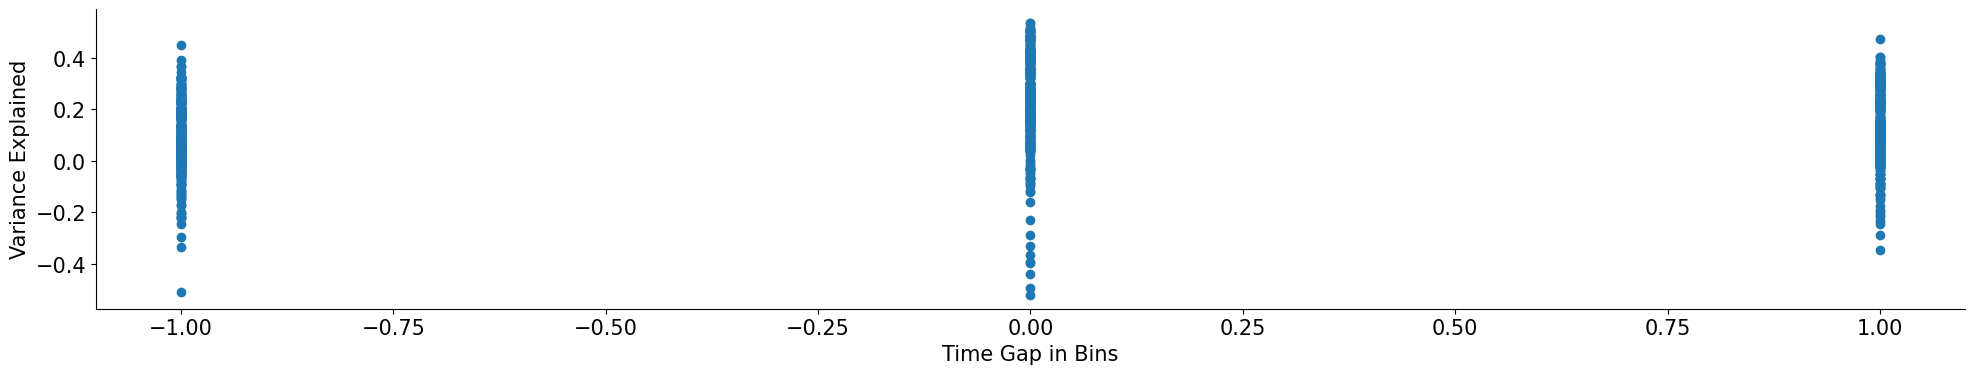

In [ ]:
plt.scatter(x=results.TimeBin, y=results.Exp_Var)
plt.xlabel('Time Gap in Bins')
plt.ylabel('Variance Explained')

In [ ]:
# Conduct the Kruskal-Wallis Test
result = stats.kruskal(position['Exp_Var'].values,distance['Exp_Var'].values,rel_change['Exp_Var'].values,direction['Exp_Var'].values)

In [ ]:
print(result)

KruskalResult(statistic=431.23095815107854, pvalue=3.799145057853002e-93)


(array([ 1.,  0.,  0.,  2.,  0.,  2.,  1.,  3.,  0.,  3.,  0.,  7.,  7.,
         2.,  8., 13.,  5., 16., 12.,  8.]),
 array([0.06267733, 0.08566956, 0.10866179, 0.13165402, 0.15464625,
        0.17763848, 0.20063072, 0.22362295, 0.24661518, 0.26960741,
        0.29259964, 0.31559187, 0.3385841 , 0.36157633, 0.38456856,
        0.40756079, 0.43055302, 0.45354525, 0.47653748, 0.49952972,
        0.52252195]),
 <BarContainer object of 20 artists>)

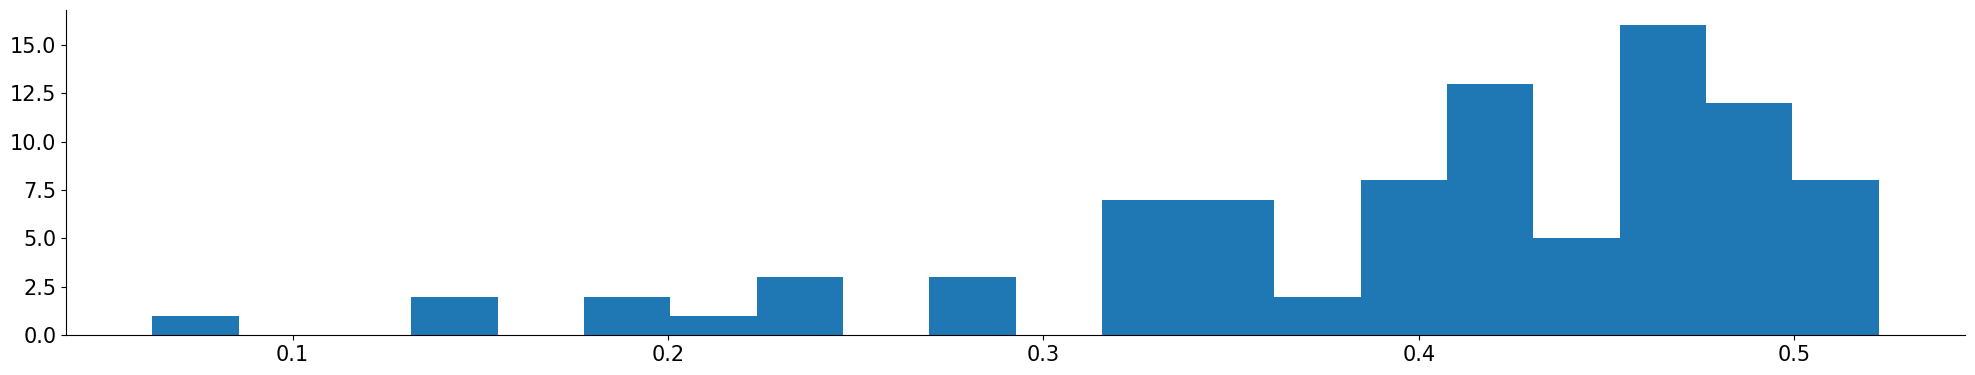

In [ ]:
plt.hist(distance['Exp_Var'].values, bins=20)

(array([ 2.,  1.,  1.,  2.,  2.,  1.,  0.,  0.,  3.,  3.,  6.,  7., 13.,
         8., 11., 17.,  7.,  5.,  0.,  1.]),
 array([-0.14773513, -0.11366256, -0.07958999, -0.04551741, -0.01144484,
         0.02262773,  0.05670031,  0.09077288,  0.12484545,  0.15891802,
         0.1929906 ,  0.22706317,  0.26113574,  0.29520832,  0.32928089,
         0.36335346,  0.39742604,  0.43149861,  0.46557118,  0.49964376,
         0.53371633]),
 <BarContainer object of 20 artists>)

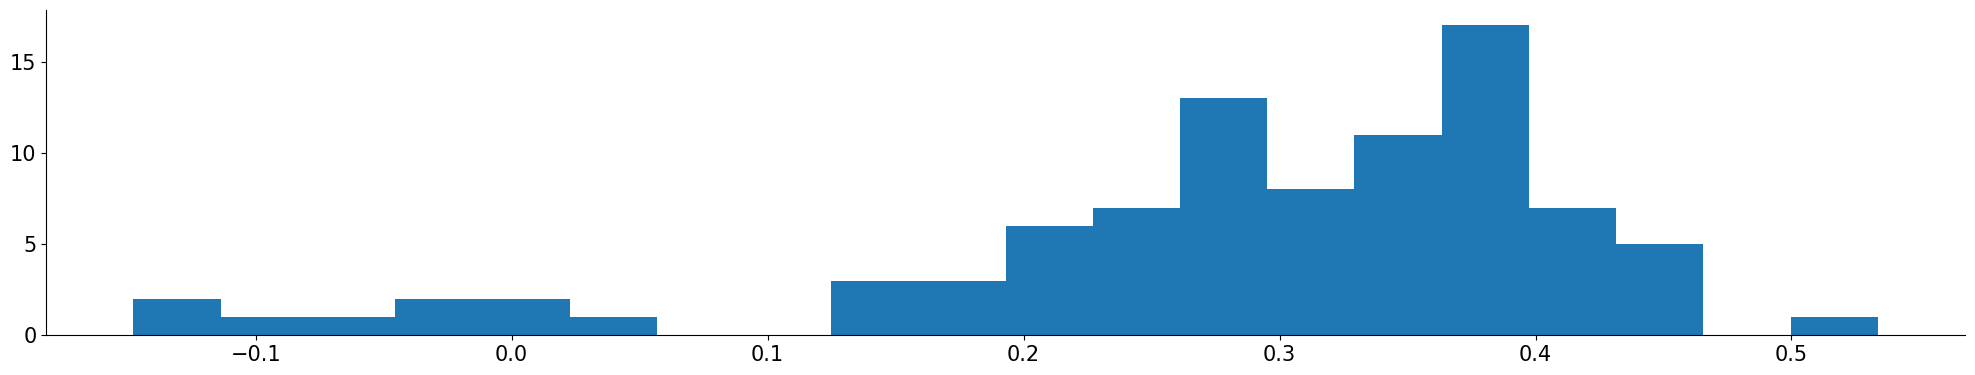

In [ ]:
plt.hist(position['Exp_Var'].values, bins=20)

(array([ 1.,  5.,  1.,  2.,  2.,  0.,  0.,  0.,  3.,  7.,  5.,  7.,  8.,
         3.,  9.,  3., 11.,  7., 12.,  4.]),
 array([-8.86641261e-02, -7.39058436e-02, -5.91475612e-02, -4.43892787e-02,
        -2.96309962e-02, -1.48727138e-02, -1.14431325e-04,  1.46438511e-02,
         2.94021336e-02,  4.41604161e-02,  5.89186985e-02,  7.36769810e-02,
         8.84352634e-02,  1.03193546e-01,  1.17951828e-01,  1.32710111e-01,
         1.47468393e-01,  1.62226676e-01,  1.76984958e-01,  1.91743241e-01,
         2.06501523e-01]),
 <BarContainer object of 20 artists>)

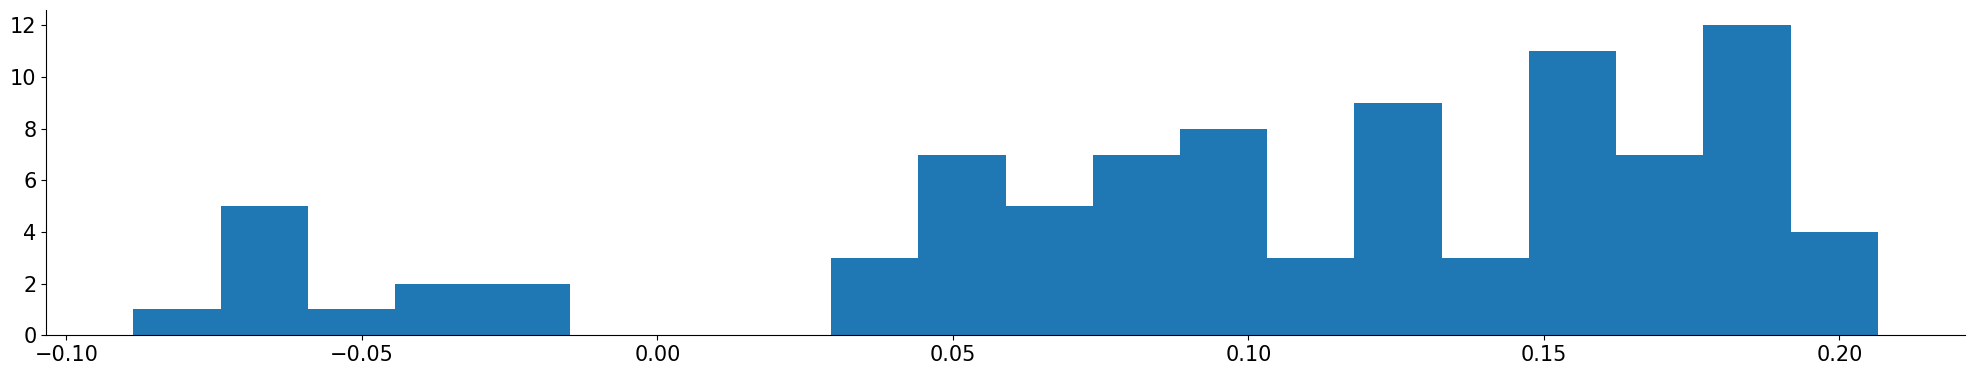

In [ ]:
plt.hist(direction['Exp_Var'].values, bins=20)

(array([ 1.,  1.,  3.,  2.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,  1.,  3.,
         5.,  5.,  7.,  9., 21., 22.,  6.]),
 array([-0.49412351, -0.45305377, -0.41198402, -0.37091427, -0.32984452,
        -0.28877477, -0.24770503, -0.20663528, -0.16556553, -0.12449578,
        -0.08342604, -0.04235629, -0.00128654,  0.03978321,  0.08085296,
         0.1219227 ,  0.16299245,  0.2040622 ,  0.24513195,  0.28620169,
         0.32727144]),
 <BarContainer object of 20 artists>)

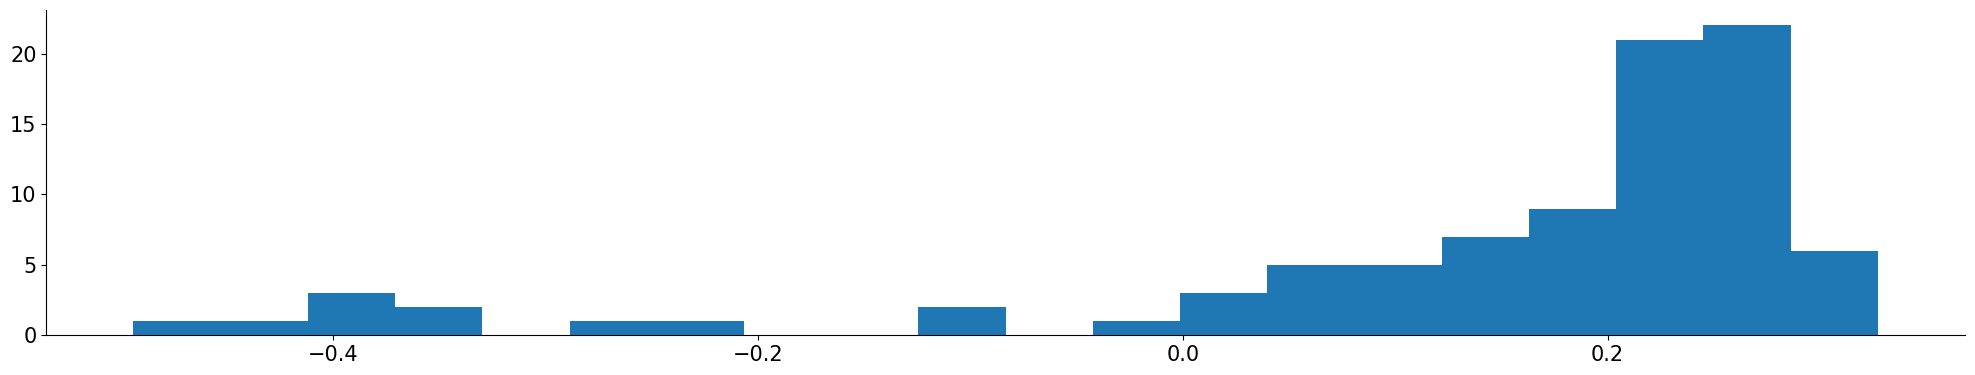

In [ ]:
plt.hist(rel_change['Exp_Var'].values, bins=20)

In [ ]:
print('variance of distance: ', distance['Exp_Var'].var())
print('variance of absolute position: ', position['Exp_Var'].var())
print('variance of direction: ', direction['Exp_Var'].var())
print('variance of relative change: ', rel_change['Exp_Var'].var())

variance of distance:  0.009292288479668953
variance of absolute position:  0.019012692099454376
variance of direction:  0.005582981487139759
variance of relative change:  0.03742298434513473


In [ ]:
# @title Subsetting Neural Data According to Depth Information
def unique(list1):
    list_set = set(list1)
    unq = (list(list_set))
    return unq
depth_values = unique(dat['xyz'][2].tolist())
depth_subsets = {}
layer = 0
for depth in depth_values:
    layer = layer + 1
    depth_indices = []
    depth_indices = (dat['xyz'][2] == depth)
    depth_subsets[layer] = dat['sresp'][depth_indices]

In [ ]:
depth_values

[-150.0, -180.0, -210.0, -240.0, -270.0, -300.0, -330.0, -360.0, -390.0]

In [ ]:
  for train_ix, test_ix in tscv.split(X):
    print(train_ix, test_ix)

[   0    1    2 ... 1170 1171 1172] [1173 1174 1175 ... 2339 2340 2341]
[   0    1    2 ... 2339 2340 2341] [2342 2343 2344 ... 3508 3509 3510]
[   0    1    2 ... 3508 3509 3510] [3511 3512 3513 ... 4677 4678 4679]
[   0    1    2 ... 4677 4678 4679] [4680 4681 4682 ... 5846 5847 5848]
[   0    1    2 ... 5846 5847 5848] [5849 5850 5851 ... 7015 7016 7017]


In [ ]:
for gap in [-2,-1,0,1,2]:
  if gap < 0:
    print(x[:gap])
    print(y[-gap:])
  elif gap > 0:
    print(x[gap:])
    print(y[:-gap])
  else:
    print(x)
    print(y)

[1, 2, 3, 4, 5]
[3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6]
[2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[1, 2, 3, 4, 5]


In [ ]:
from sklearn import preprocessing
preprocessing.normalize(Y)

for vec in Y:

  Y_norm.append(preprocessing.normalize(vec))
  print(Y_norm.shape)

In [ ]:
Z = zscore(depth_subsets[1].T, axis=1)
X = np.nan_to_num(Z)


x_change = np.diff(dat['pupilCOM'][:,0])
y_change = np.diff(dat['pupilCOM'][:,1])
Y = np.vstack((x_change,y_change)).T
Y = np.vstack((np.array([0,0]), Y))
Y = np.nan_to_num(Y)

In [ ]:
## relative change
gaps = [-2,-1,0,1,2]
mses =  np.zeros((len(depth_subsets),len(gaps)))
vars =  np.zeros((len(depth_subsets),len(gaps)))
for layer in range(1,len(depth_subsets)+1):
  Z = zscore(depth_subsets[layer].T, axis=1)
  X = np.nan_to_num(Z)


  x_change = np.diff(dat['pupilCOM'][:,0])
  y_change = np.diff(dat['pupilCOM'][:,1])
  Y = np.vstack((x_change,y_change)).T
  Y = np.vstack((np.array([0,0]), Y))
  Y = np.nan_to_num(Y)

  for i, gap in enumerate(gaps):
    if gap < 0:
      X_shifted = X[:gap]
      Y_shifted = Y[-gap:]
    elif gap > 0:
      X_shifted = X[gap:]
      Y_shifted = Y[:-gap]
    else:
      X_shifted = X
      Y_shifted = Y


    tscv = TimeSeriesSplit(n_splits=5, gap=0)
    for train_ix, test_ix in tscv.split(X_shifted):
      #print(train_ix, test_ix)
      print('')

    X_train = X_shifted[train_ix]
    X_test = X_shifted[test_ix]
    Y_train = Y_shifted[train_ix]
    Y_test = Y_shifted[test_ix]




    #GLM model
    model = linear_model.LinearRegression()
    model.fit(X_train,Y_train)
    #model = sm.GLM(family=sm.families.Poisson())
    #result = model.fit()
    y_pred = model.predict(X_test)




    mse = mean_squared_error(Y_test, y_pred)
    var = explained_variance_score(Y_test, y_pred)

    mses[layer-1][i] = mse
    vars[layer-1][i] = var


    print(f'Predictions from neurons in layer {layer} and gap of {gap}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Explained Variance: {var}')




In [ ]:
# magnmitude of movement
gaps = [-2,-1,0,1,2]

for layer in range(1,len(depth_subsets)+1):
  Z = zscore(depth_subsets[layer].T, axis=1)
  X = np.nan_to_num(Z)

  x_change  = np.diff(dat['pupilCOM'][:,0])
  y_change = np.diff(dat['pupilCOM'][:,1])
  Y = np.vstack((x_change,y_change)).T
  Y = np.vstack((np.array([0,0]), Y))
  Y = np.nan_to_num(Y)
  Y = np.array([np.sqrt(x**2+y**2) for x,y in Y])

  for i, gap in enumerate(gaps):
    if gap < 0:
      X_shifted = X[:gap]
      Y_shifted = Y[-gap:]
    elif gap > 0:
      X_shifted = X[gap:]
      Y_shifted = Y[:-gap]
    else:
      X_shifted = X
      Y_shifted = Y


    tscv = TimeSeriesSplit(n_splits=5, gap=0)
    for train_ix, test_ix in tscv.split(X_shifted):
      #print(train_ix, test_ix)
      print('')

    X_train = X_shifted[train_ix]
    X_test = X_shifted[test_ix]
    Y_train = Y_shifted[train_ix]
    Y_test = Y_shifted[test_ix]




    #GLM model
    model = LinearRegression()
    model.fit(X_train,Y_train)
    #model = sm.GLM(family=sm.families.Poisson())
    #result = model.fit()
    y_pred = model.predict(X_test)




    mse = mean_squared_error(Y_test, y_pred)
    var = explained_variance_score(Y_test, y_pred)




    print(f'Predictions from neurons in layer {layer} and gap of {gap}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Explained Variance: {var}')








Predictions from neurons in layer 1 and gap of -2:
Mean Squared Error: 12.85047316953404
Explained Variance: -0.13841162877556656





Predictions from neurons in layer 1 and gap of -1:
Mean Squared Error: 11.200180302176776
Explained Variance: 0.0063080461719503544





Predictions from neurons in layer 1 and gap of 0:
Mean Squared Error: 7.273210358876405
Explained Variance: 0.3606115679630907





Predictions from neurons in layer 1 and gap of 1:
Mean Squared Error: 10.134965563561309
Explained Variance: 0.08088401123674716





Predictions from neurons in layer 1 and gap of 2:
Mean Squared Error: 10.867592764683739
Explained Variance: 0.0164970077281984





Predictions from neurons in layer 2 and gap of -2:
Mean Squared Error: 11.94079749470122
Explained Variance: -0.05915106955797045





Predictions from neurons in layer 2 and gap of -1:
Mean Squared Error: 10.373241731996487
Explained Variance: 0.07964272100719716





Predictions from neurons in layer 2 and gap of 0:
Mean

In [ ]:
# absolute position
gaps = [-2,-1,0,1,2]

for layer in range(1,len(depth_subsets)+1):
  Z = zscore(depth_subsets[layer].T, axis=1)
  X = np.nan_to_num(Z)


  Y = dat['pupilCOM']
  Y = np.nan_to_num(Y)

  for i, gap in enumerate(gaps):
    if gap < 0:
      X_shifted = X[:gap]
      Y_shifted = Y[-gap:]
    elif gap > 0:
      X_shifted = X[gap:]
      Y_shifted = Y[:-gap]
    else:
      X_shifted = X
      Y_shifted = Y


    tscv = TimeSeriesSplit(n_splits=5, gap=0)
    for train_ix, test_ix in tscv.split(X_shifted):
      #print(train_ix, test_ix)
      print('')

    X_train = X_shifted[train_ix]
    X_test = X_shifted[test_ix]
    Y_train = Y_shifted[train_ix]
    Y_test = Y_shifted[test_ix]




    #GLM model
    model = linear_model.LinearRegression()
    model.fit(X_train,Y_train)
    #model = sm.GLM(family=sm.families.Poisson())
    #result = model.fit()
    y_pred = model.predict(X_test)




    mse = mean_squared_error(Y_test, y_pred)
    var = explained_variance_score(Y_test, y_pred)




    print(f'Predictions from neurons in layer {layer} and gap of {gap}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Explained Variance: {var}')




In [ ]:
## pca 50 components
import random

random.seed(42)
gaps = [-2,-1,0,1,2]
mses =  np.zeros((len(depth_subsets),len(gaps)))
vars =  np.zeros((len(depth_subsets),len(gaps)))
for layer in range(1,len(depth_subsets)+1):
  Z = zscore(depth_subsets[layer].T, axis=1)
  X = np.nan_to_num(Z)
  pca = PCA(n_components=50)
  X_pca = pca.fit_transform(X)


  x_change = np.diff(dat['pupilCOM'][:,0])
  y_change = np.diff(dat['pupilCOM'][:,1])
  Y = np.vstack((x_change,y_change)).T
  Y = np.vstack((np.array([0,0]), Y))
  Y = np.nan_to_num(Y)

  for i, gap in enumerate(gaps):
    if gap < 0:
      X_shifted = X_pca[:gap]
      Y_shifted = Y[-gap:]
    elif gap > 0:
      X_shifted = X_pca[gap:]
      Y_shifted = Y[:-gap]
    else:
      X_shifted = X_pca
      Y_shifted = Y


    tscv = TimeSeriesSplit(n_splits=5, gap=0)
    for train_ix, test_ix in tscv.split(X_shifted):
      #print(train_ix, test_ix)
      print('')

    X_train = X_shifted[train_ix]
    X_test = X_shifted[test_ix]
    Y_train = Y_shifted[train_ix]
    Y_test = Y_shifted[test_ix]




    #GLM model
    model = linear_model.LinearRegression()
    model.fit(X_train,Y_train)
    #model = sm.GLM(family=sm.families.Poisson())
    #result = model.fit()
    y_pred = model.predict(X_test)




    mse = mean_squared_error(Y_test, y_pred)
    var = explained_variance_score(Y_test, y_pred)

    mses[layer-1][i] = mse
    vars[layer-1][i] = var


    print(f'Predictions from neurons in layer {layer} and gap of {gap}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Explained Variance: {var}')




Text(0.5, 1.0, 'MSE')

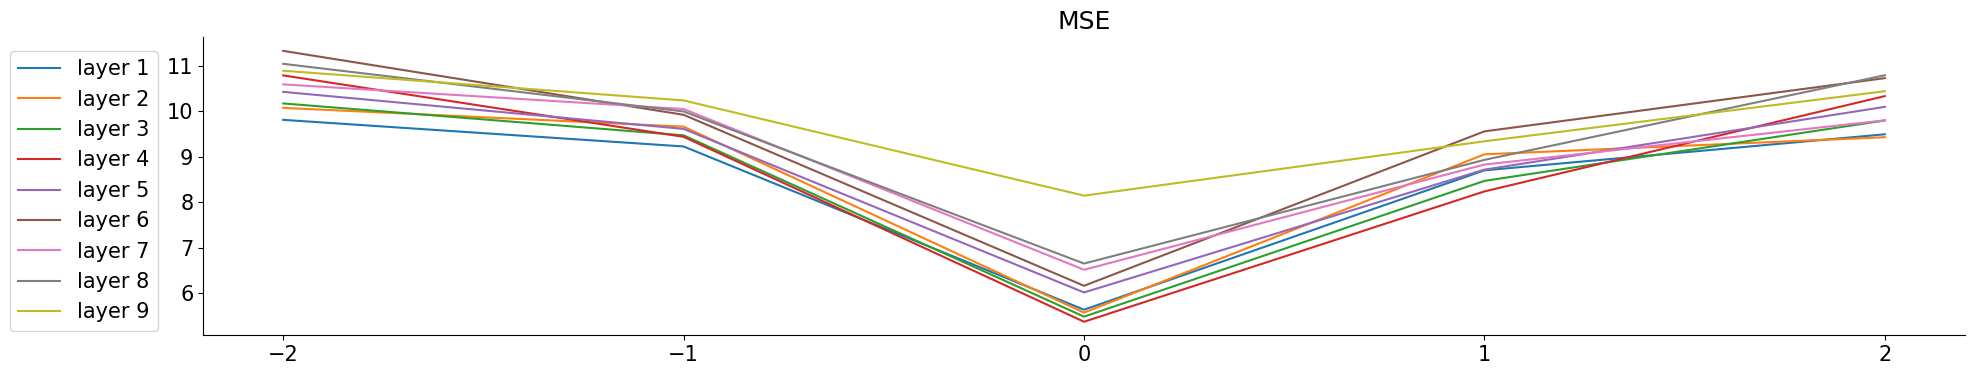

In [ ]:
fig,ax = plt.subplots()
ax.plot(gaps, mses.T, label=['layer 1','layer 2','layer 3','layer 4','layer 5','layer 6','layer 7','layer 8','layer 9'])
ax.set_xticks(gaps)
ax.legend(loc='lower right',bbox_to_anchor=(-0.02, -0.02))
ax.set_title('MSE')

Text(0.5, 1.0, 'Variance explained')

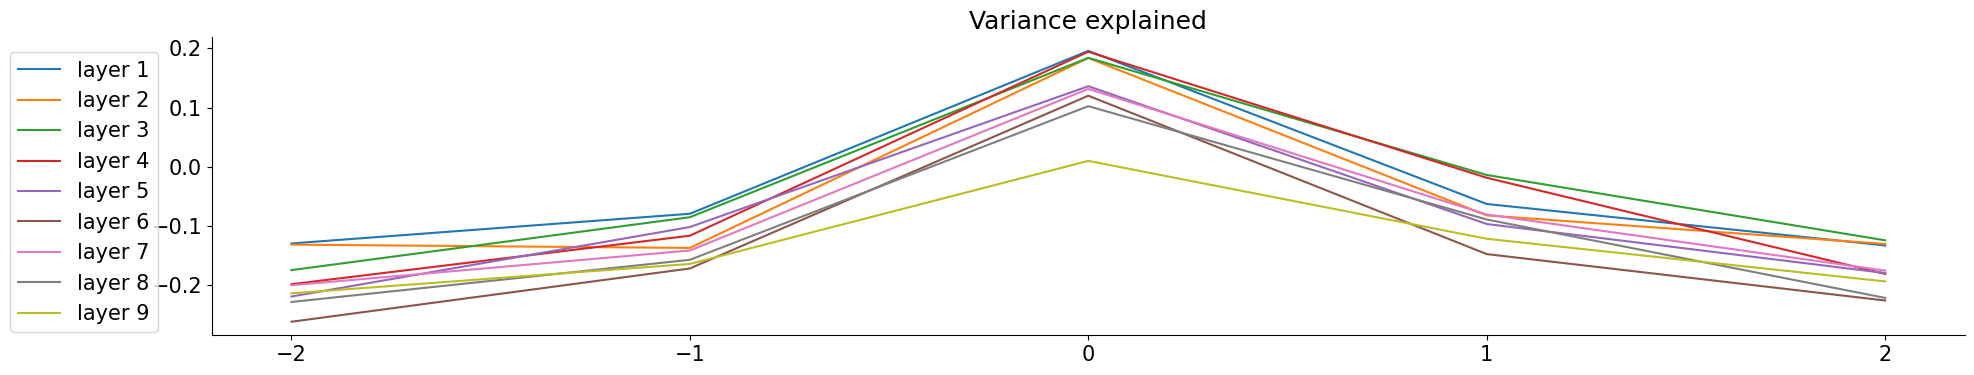

In [ ]:
fig,ax = plt.subplots()
ax.plot(gaps, vars.T, label=['layer 1','layer 2','layer 3','layer 4','layer 5','layer 6','layer 7','layer 8','layer 9'])
ax.set_xticks(gaps)
ax.legend(loc='lower right',bbox_to_anchor=(-0.025, -0.025))
ax.set_title('Variance explained')

Text(0.5, 1.0, 'Prediction of Eye Movement X')

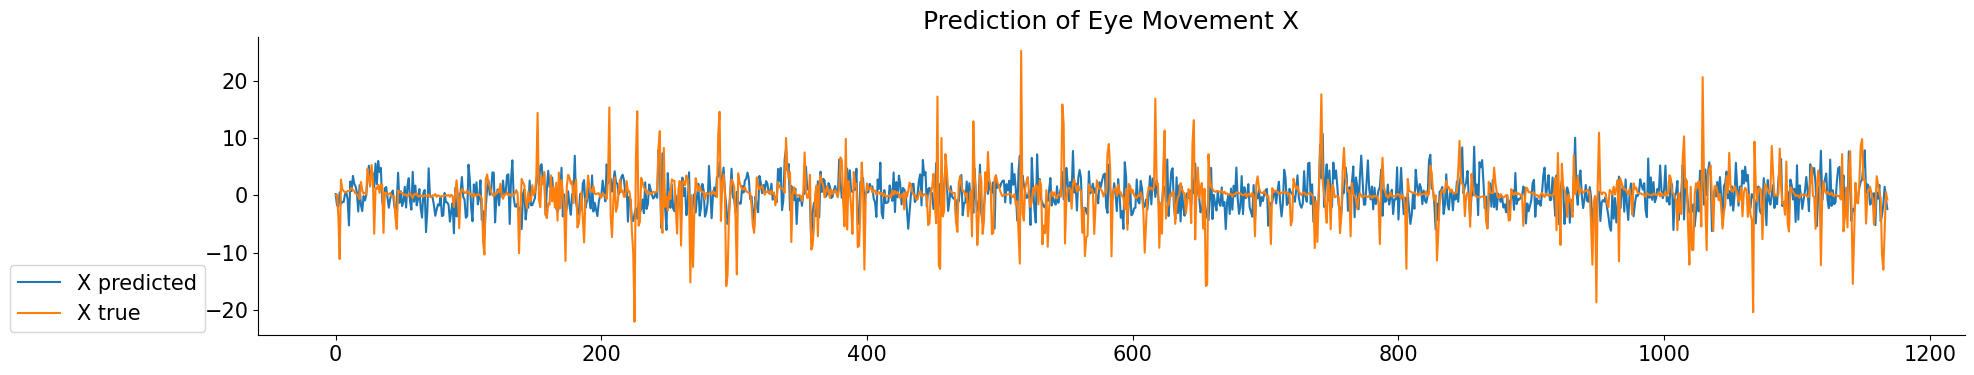

In [ ]:
fig,ax = plt.subplots()
ax.plot(range(len(y_pred)), y_pred[:,0], label='X predicted')
#ax.plot(range(len(y_pred)), y_pred[:,1], label='Y predicted')
ax.plot(range(len(y_pred)), Y_test[:,0], label='X true')
#ax.plot(range(len(y_pred)), Y_test[:,1], label='Y true')
ax.legend(loc='lower right',bbox_to_anchor=(-0.025, -0.025))
ax.set_title('Prediction of Eye Movement X')

Text(0.5, 1.0, 'Prediction of Eye Movement Y')

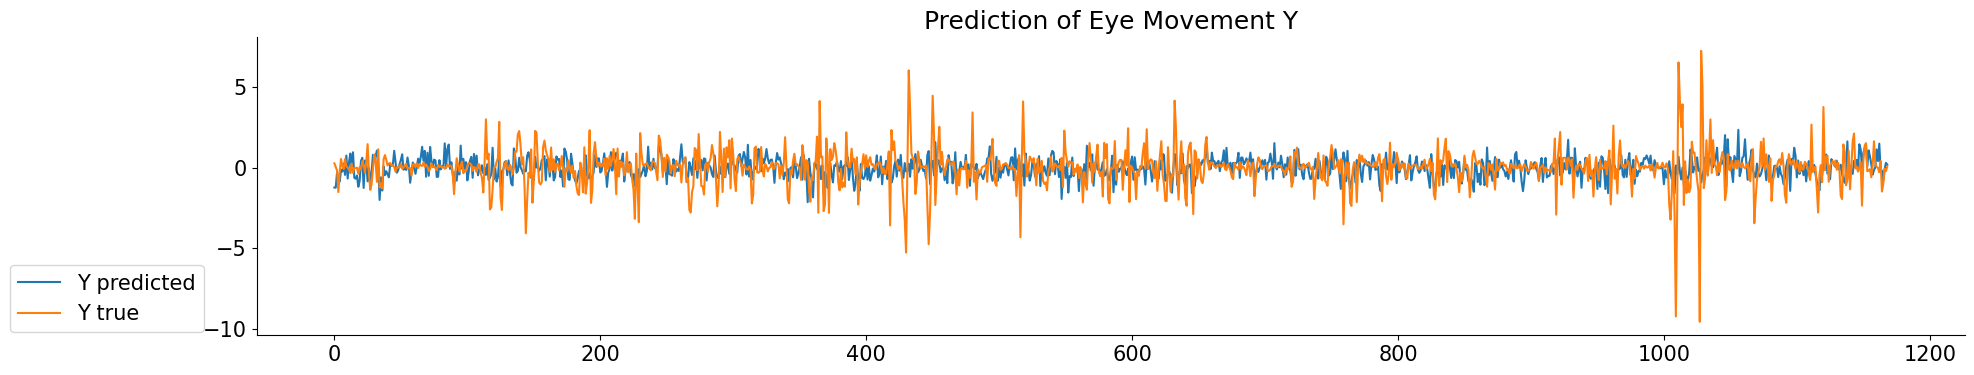

In [ ]:
fig,ax = plt.subplots()
#ax.plot(range(len(y_pred)), y_pred[:,0], label='X predicted')
ax.plot(range(len(y_pred)), y_pred[:,1], label='Y predicted')
#ax.plot(range(len(y_pred)), Y_test[:,0], label='X true')
ax.plot(range(len(y_pred)), Y_test[:,1], label='Y true')
ax.legend(loc='lower right',bbox_to_anchor=(-0.025, -0.025))
ax.set_title('Prediction of Eye Movement Y')

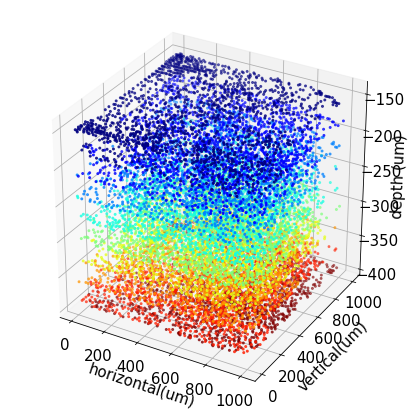

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

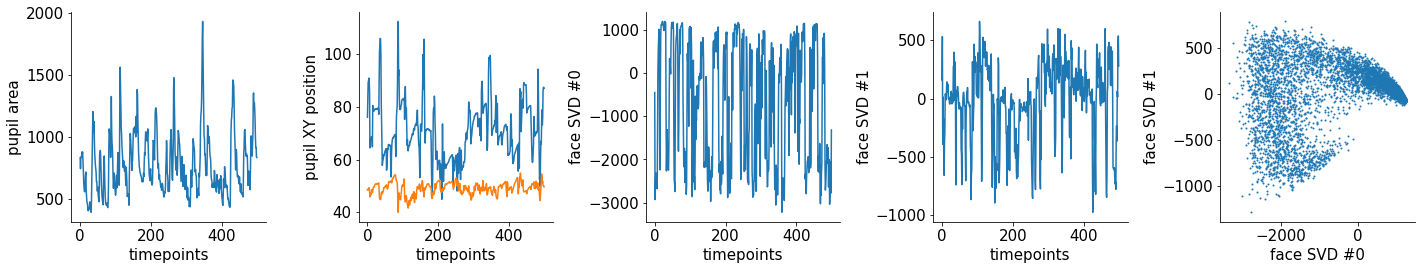

In [ ]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

In [ ]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)

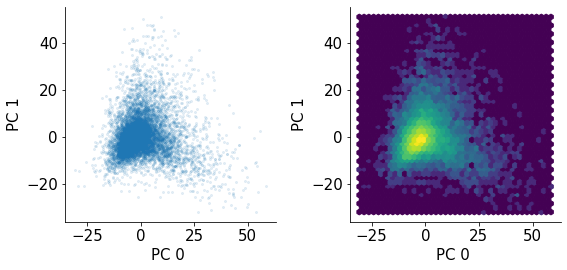

In [ ]:
# @title Plot PCs. Too many points, switch to logarithmic hexbin!
ax = plt.subplot(1, 5, 1)
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=.1)
ax.set(xlabel='PC 0 ', ylabel='PC 1')

ax = plt.subplot(1, 5, 2)
plt.hexbin(X[:, 0], X[:, 1], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 1', alpha=.1)

plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions.

ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=20,
             metric='correlation', transform_seed=42).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

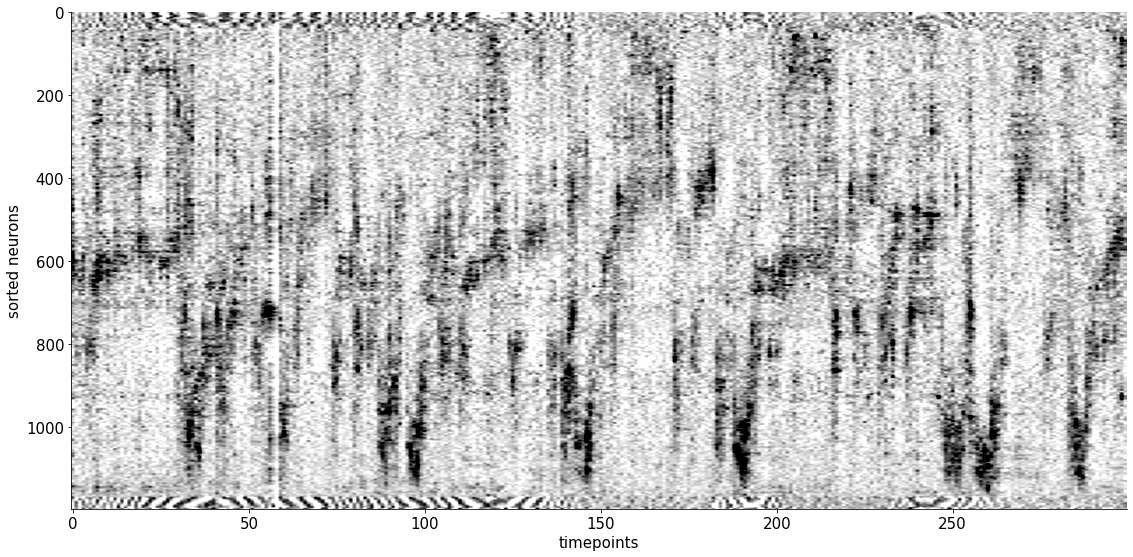

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='sorted neurons')
plt.show()